This code is designed for visualizing word embeddings of a trained large language model.

The script starts by importing necessary libraries for neural network construction, data handling, and visualization. It reads configuration settings from a YAML file, setting up paths for training, validation, and test data, and defining various parameters like minimum word frequency, context size, and hyperparameters for the neural network.

A `WikiText2VocabBuilder` class is defined to build a vocabulary from the text corpus. It preprocesses the text, tokenizes it, and constructs a mapping of words to indices, considering only words that meet a specified frequency threshold. Special tokens for start, end, unknown words, hyphens, and numerical commas are handled.

The `WikiText2Dataset` class, derived from PyTorch's `Dataset`, prepares the data for the language modeling task. It processes the text data into input-output pairs suitable for training a language model, where the input is a sequence of words, and the output is the word following this sequence.

The `LanguageModel` class defines the neural network architecture for the language modeling task. It includes an embedding layer, multiple hidden layers with ReLU activation and layer normalization, and an output layer. The network is designed with residual connections and uses Kaiming initialization for its weights, which is beneficial for training deep networks.

The model is then loaded with pre-trained weights from a specified path.

For visualization, the code uses PCA (Principal Component Analysis) to reduce the dimensionality of the word embeddings to four dimensions. It then selects specific regions of interest in the reduced space and plots these embeddings in a 3D space, coloring them based on the fourth dimension. This visualization helps in understanding the distribution and clustering of word embeddings in the reduced space.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict, Counter

import random
import string
import math
import sys
import yaml
import json
import string
import math
import sys
import logging

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


Loading the configuration.

In [ ]:
with open("testRunConfig.yaml", 'r') as ymlfile:
    config = yaml.safe_load(ymlfile)

training_data_corpus_path = config['data']['training_data_corpus_path']
validation_data_corpus_path = config['data']['validation_data_corpus_path']
test_data_corpus_path = config['data']['test_data_corpus_path']
min_freq = config['data']['min_freq']
context_size = config['data']['context_size']

shuffle = config['runtime']['shuffle']
num_workers = config['runtime']['num_workers']
batch_size = config['runtime']['batch_size']
config_device = config['runtime']['device']


total_epochs = config['experiment']['total_epochs']
patience = config['experiment']['patience']
lr_start = config['hyperparameters']['lr_start']
weight_decay = config['hyperparameters']['weight_decay']
lr_end = config['hyperparameters']['lr_end']
numberOfLayers = config['hyperparameters']['numberOfLayers'] # Number of hidden layers
embed_size= config['hyperparameters']['embed_size']  # The embedding size of the words
hidden_size = config['hyperparameters']['hidden_size'] # The hidden size of the neural network


Preparation of Data.

In [ ]:
class WikiText2VocabBuilder:
    def _new_index(self):
        return len(self.word2index)

    def __init__(self, corpus_path, min_freq):
        self.corpus_path = corpus_path
        self.min_freq = min_freq
        self.word2index = defaultdict(self._new_index)
        self.index2word = {}
        self.word_freqs = Counter()
        self.cleaned_sentences = []

        self.START_TOKEN = "<s>"
        self.END_TOKEN = "</s>"
        self.UNK_TOKEN = "<unk>"
        self.hyphentoken = "hyphentoken"
        self.numericalcommatoken = "numericalcommatoken"

        self._initialize_special_tokens()
        self._load_and_preprocess()

    def _initialize_special_tokens(self):
        self.word2index[self.START_TOKEN] = 0
        self.word2index[self.END_TOKEN] = 1
        self.word2index[self.UNK_TOKEN] = 2
        self.word2index[self.hyphentoken] = 3
        self.word2index[self.numericalcommatoken] = 4

        self.index2word[0] = self.START_TOKEN
        self.index2word[1] = self.END_TOKEN
        self.index2word[2] = self.UNK_TOKEN
        self.index2word[3] = self.hyphentoken
        self.index2word[4] = self.numericalcommatoken


    def clean_and_tokenize(self, corpus):
        corpus = corpus.lower()  # Convert to lowercase
        sentences = sent_tokenize(corpus)
        cleaned_sentences = []
        for sentence in sentences:
            sentence = sentence.strip()  # Remove unnecessary whitespaces
            if not (sentence.startswith('=') or sentence.endswith('=')):  # Exclude headers
                sentence = sentence.replace('<unk>', 'unknowntoken')
                sentence = sentence.replace('@-@', 'hyphentoken')
                sentence = sentence.replace('@,@', 'numericalcommatoken')
                cleaned_sentences.append(sentence)
        return cleaned_sentences

    def _load_and_preprocess(self):
        with open(self.corpus_path, 'r') as f:
            corpus = f.read()

        # Split the text into sentences using NLTK
        self.cleaned_sentences = self.clean_and_tokenize(corpus)
        # Count word frequencies
        for sentence in self.cleaned_sentences:
            words = word_tokenize(sentence)
            for word in words:
                word = word.lower()
                self.word_freqs[word] += 1

        # Build the vocabulary using only words that meet the frequency threshold
        for word, freq in self.word_freqs.items():
            if freq >= self.min_freq:
                index = self.word2index[word]
                self.index2word[index] = word

    def vocab_size(self):
        return len(self.word2index)



In [ ]:
class WikiText2Dataset(Dataset):
    def __init__(self, preprocessor, context_size):
        super(WikiText2Dataset, self).__init__()

        self.context_size = context_size

        # We already have cleaned sentences in the preprocessor
        self.sentences = preprocessor.cleaned_sentences
        self.word2index = preprocessor.word2index
        self.index2word = preprocessor.index2word
        self.word_freqs = preprocessor.word_freqs
        self.START_TOKEN = preprocessor.START_TOKEN
        self.END_TOKEN = preprocessor.END_TOKEN
        self.UNK_TOKEN = preprocessor.UNK_TOKEN
        self.hyphentoken = preprocessor.hyphentoken
        self.numericalcommatoken = preprocessor.numericalcommatoken


        self.X, self.Y = self._build_dataset()

    def _build_dataset(self):
        X, Y = [], []

        for sentence in self.sentences:
            words = word_tokenize(sentence)
            if not words:
                continue
            if words[-1] in string.punctuation:
                words[-1] = self.END_TOKEN
            else:
                words.append(self.END_TOKEN)

            context = [0] * self.context_size
            for i, word in enumerate(words):

                if word in self.word2index and word not in ['unknowntoken', 'hyphentoken', 'numericalcommatoken']:
                    index = self.word2index[word]
                elif word == 'unknowntoken':
                    index = self.word2index[self.UNK_TOKEN]
                elif word == 'hyphentoken':
                    index = self.word2index[self.hyphentoken]
                elif word == 'numericalcommatoken':
                   index = self.word2index[self.numericalcommatoken]
                else:
                    index = self.word2index[self.UNK_TOKEN]
                X.append(context)
                Y.append(index)
                context = context[1:] + [index]

        return torch.tensor(X), torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def sample(self, num_samples):
        for _ in range(num_samples):
            idx = torch.randint(0, len(self), (1,)).item()
            context, target = self.X[idx], self.Y[idx]
            context_words = [self.index2word[i.item()] for i in context]
            target_word = self.index2word[target.item()]
            print(" ".join(context_words), "------>", target_word)

    def get_context_size(self):
        return self.context_size


In [ ]:
train_vocabBuilder =  WikiText2VocabBuilder(corpus_path = training_data_corpus_path, min_freq=min_freq)


Defining the language model class so that we can load our trained model.

In [ ]:
class LanguageModel(nn.Module):

    def __init__(self, vocab_size, embed_size, hidden_size, context_size, numberOfLayers):
        super(LanguageModel, self).__init__()
        self.embed_size = embed_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.numberOfLayers = numberOfLayers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_layers = nn.ModuleList()
        self.ReLU = nn.ReLU()  # Defining a single instance of ReLU to reuse


        self.embeddingToHiddenLayer = nn.Linear((self.context_size) * self.embed_size, self.hidden_size)
        self.hiddenToOutputLayer = nn.Linear(self.hidden_size, self.vocab_size)

        # Hidden layers weights, bias, and layer normalization
        for i in range(self.numberOfLayers):
            linear_layer = nn.Linear((self.context_size) * self.embed_size if i == 0 else self.hidden_size, self.hidden_size)
            layer_norm = nn.LayerNorm(self.hidden_size)
            ReLULayer = nn.ReLU()


            self.hidden_layers.append(nn.Sequential(
                linear_layer,
                layer_norm,
                self.ReLU
            ))

        self.output_layer = nn.Linear(self.hidden_size, self.vocab_size)

        with torch.no_grad():
            # Xavier initialization for embedding
            nn.init.kaiming_normal_(self.embedding.weight)
            nn.init.kaiming_normal_(self.embeddingToHiddenLayer.weight)
            nn.init.constant_(self.embeddingToHiddenLayer.bias, 0)

            nn.init.kaiming_normal_(self.hiddenToOutputLayer.weight)
            nn.init.constant_(self.hiddenToOutputLayer.bias, 0)


            # Kaiming initialization for linear layers
            for hidden_layer in self.hidden_layers:
                nn.init.kaiming_normal_(hidden_layer[0].weight)

            # Initialize batch normalization layers
            for hidden_layer in self.hidden_layers:
                nn.init.constant_(hidden_layer[1].weight, 1)
                nn.init.constant_(hidden_layer[1].bias, 0)

            # Make the output layer less confident
            nn.init.constant_(self.output_layer.weight, 0.01)
            nn.init.constant_(self.output_layer.bias, 0)

    def forward(self, x):

        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        residual = self.embeddingToHiddenLayer(x)

        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x) + residual
            residual = x

        residual = self.hiddenToOutputLayer(x)
        y = self.output_layer(x) + residual
        log_probs = F.log_softmax(y, dim=1)
        return log_probs

    def num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

Setting seeds for reproducibility.

In [ ]:
np.random.seed(423455335)
torch.manual_seed(423455335)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Instantiating the model and loading the trained weights.

In [ ]:
vocab_size = train_vocabBuilder.vocab_size() # The size of the vocabulary
model = LanguageModel(vocab_size, embed_size, hidden_size, context_size, numberOfLayers)
model_save_path = "./embedding_vis_weights.pth"
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

Examining how the model continues text sequences.

In [ ]:
from collections import deque

def generate_text(model, start_words, max_length=20):
    #set seed
    torch.manual_seed(423455335)
    model.eval()
    with torch.no_grad():
        # Initialize deque with the specified start words and fill the rest with a placeholder word
        word_deque = deque(["<s>"] * (10 - len(start_words)) + start_words, maxlen=10)
        generated_text = list(start_words)

        end_token_count = 0
        for _ in range(max_length):
            input_indices = [train_vocabBuilder.word2index[word] for word in word_deque]  # Get indices of words in deque
            input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0)  # Convert to tensor and add batch dimension
            log_probs = model(input_tensor)
            probs = torch.exp(log_probs)
            next_word_id = torch.multinomial(probs[0], num_samples=1).item()  # Adjusted index to match tensor shape
            next_word = train_vocabBuilder.index2word[next_word_id]
            generated_text.append(next_word)
            word_deque.append(next_word)  # Update the deque with the newly generated word
            if next_word == train_vocabBuilder.END_TOKEN:
                end_token_count += 1
                if end_token_count == 1:
                    break

            generated_sentence = ' '.join(generated_text)
        return generated_sentence

# Example usage
start_words = ["machines", "are"]
sentence1 = generate_text(model, start_words)
print(sentence1)
start_words2 = ["humans", "are"]
sentence2 = generate_text(model, start_words2)
print(sentence2)
start_words = ["animals", "are"]
sentence1 = generate_text(model, start_words)
print(sentence1)
start_words = ["things", "are"]
sentence1 = generate_text(model, start_words)
print(sentence1)
start_words = ["flowers", "are"]
sentence1 = generate_text(model, start_words)
print(sentence1)



machines are run from all individuals , and books are different
humans are run and may form to form a <unk> , as he had no
animals are run by a <unk> , and after an coastal caves
things are run by all individuals , and you are like to other football
flowers are run of all their forms , followed by english football


The visualization aspect of the code is centered around analyzing and displaying the word embeddings learned by the neural network model. This is achieved through dimensionality reduction and 3D plotting techniques.

1. **Dimensionality Reduction with PCA**:
   - The code uses Principal Component Analysis (PCA), a popular dimensionality reduction technique, to transform the high-dimensional word embeddings into a lower-dimensional space. Specifically, it reduces the embeddings to four dimensions. This step is crucial because it makes it possible to visualize the embeddings, which originally exist in a much higher-dimensional space (defined by the `embed_size` parameter in the model).

2. **Preparing for Visualization**:
   - The embeddings for all words in the vocabulary are extracted from the model's embedding layer and then transformed using PCA.
   - The transformed embeddings (`reduced_embeddings`) now exist in a 4-dimensional space.

3. **Defining Regions of Interest (ROI)**:
   - The code specifies two regions of interest in the reduced embedding space. Each region is defined by limits along the first three principal components and a range for the fourth dimension. These regions are subsets of the entire embedding space, likely chosen to highlight specific clusters or areas of interest.

4. **3D Scatter Plot**:
   - For visualization, the code uses a 3D scatter plot. Two separate plots are created, each corresponding to one of the defined ROIs.
   - The scatter plot is drawn using the first three dimensions of the PCA-reduced embeddings as the x, y, and z coordinates. The color of the points in the scatter plot is determined by the value of the fourth dimension, providing an additional layer of information. This color mapping helps to visualize how the embeddings are distributed along the fourth principal component within each ROI.

5. **Enhancing the Plot**:
   - Each word in the reduced space is plotted as a point, and the actual word is annotated next to its corresponding point. This step is crucial for interpretability, as it allows one to see which words are positioned close to each other in the reduced space.
   - The plot is configured with labels for axes, a color bar to interpret the fourth dimension, and other aesthetic settings to improve readability.

6. **Filtering Based on ROI**:
   - The function `filter_indices_based_on_region` is used to filter out the embeddings that fall within the specified ROIs. This filtering is based on the limits set for each of the first three dimensions and the fourth dimension.

7. **Plotting and Saving the Results**:
   - The embeddings that fall within each ROI are plotted in separate subplots.
   - The final figure, containing both subplots, is saved as an image file. This saved visualization can be used for further analysis or presentation purposes.

In essence, the visualization part of the code is focused on exploring and displaying the relationships and clusters within the word embeddings learned by the model, using PCA for dimensionality reduction and 3D scatter plots for graphical representation. This approach is particularly useful for gaining insights into the semantic relationships that the model has learned to capture in its embedding space.

In [ ]:


def plot_data(ax, x_lim, y_lim, z_lim, embeddings, words, fourth_dim_values, reduced_embeddings):
    color_map = plt.cm.viridis  # Define the colormap here

    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=fourth_dim_values, cmap='viridis')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_zlim(z_lim)

    # Labels and titles
    ax.set_xlabel('PC 1', size=15)
    ax.set_ylabel('PC 2', size=15)
    ax.set_zlabel('PC 3', size=15)

    # Use the passed arguments instead of relying on external variables
    for i, word in enumerate(words):
        ax.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], c=fourth_dim_values[i], s=40, alpha=0.7, edgecolors='w')
        ax.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], word, fontsize=16, ha='right')

    ax.grid(True)

    # Colorbar settings
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=fourth_dim_values.min(), vmax=fourth_dim_values.max()))
    sm._A = []
    cbar = plt.colorbar(sm, ax=ax, shrink=0.4, aspect=14)  # Shrink parameter set to 0.4
    cbar.set_label('PC 4', size=12)


In [ ]:
def filter_indices_based_on_region(embeddings, x_lim, y_lim, z_lim, fourth_dim_lim):

    return np.where(
        (embeddings[:, 0] > x_lim[0]) &
        (embeddings[:, 0] < x_lim[1]) &
        (embeddings[:, 1] > y_lim[0]) &
        (embeddings[:, 1] < y_lim[1]) &
        (embeddings[:, 2] > z_lim[0]) &
        (embeddings[:, 2] < z_lim[1]) &
        (embeddings[:, 3] > fourth_dim_lim[0]) &
        (embeddings[:, 3] < fourth_dim_lim[1])
    )[0]


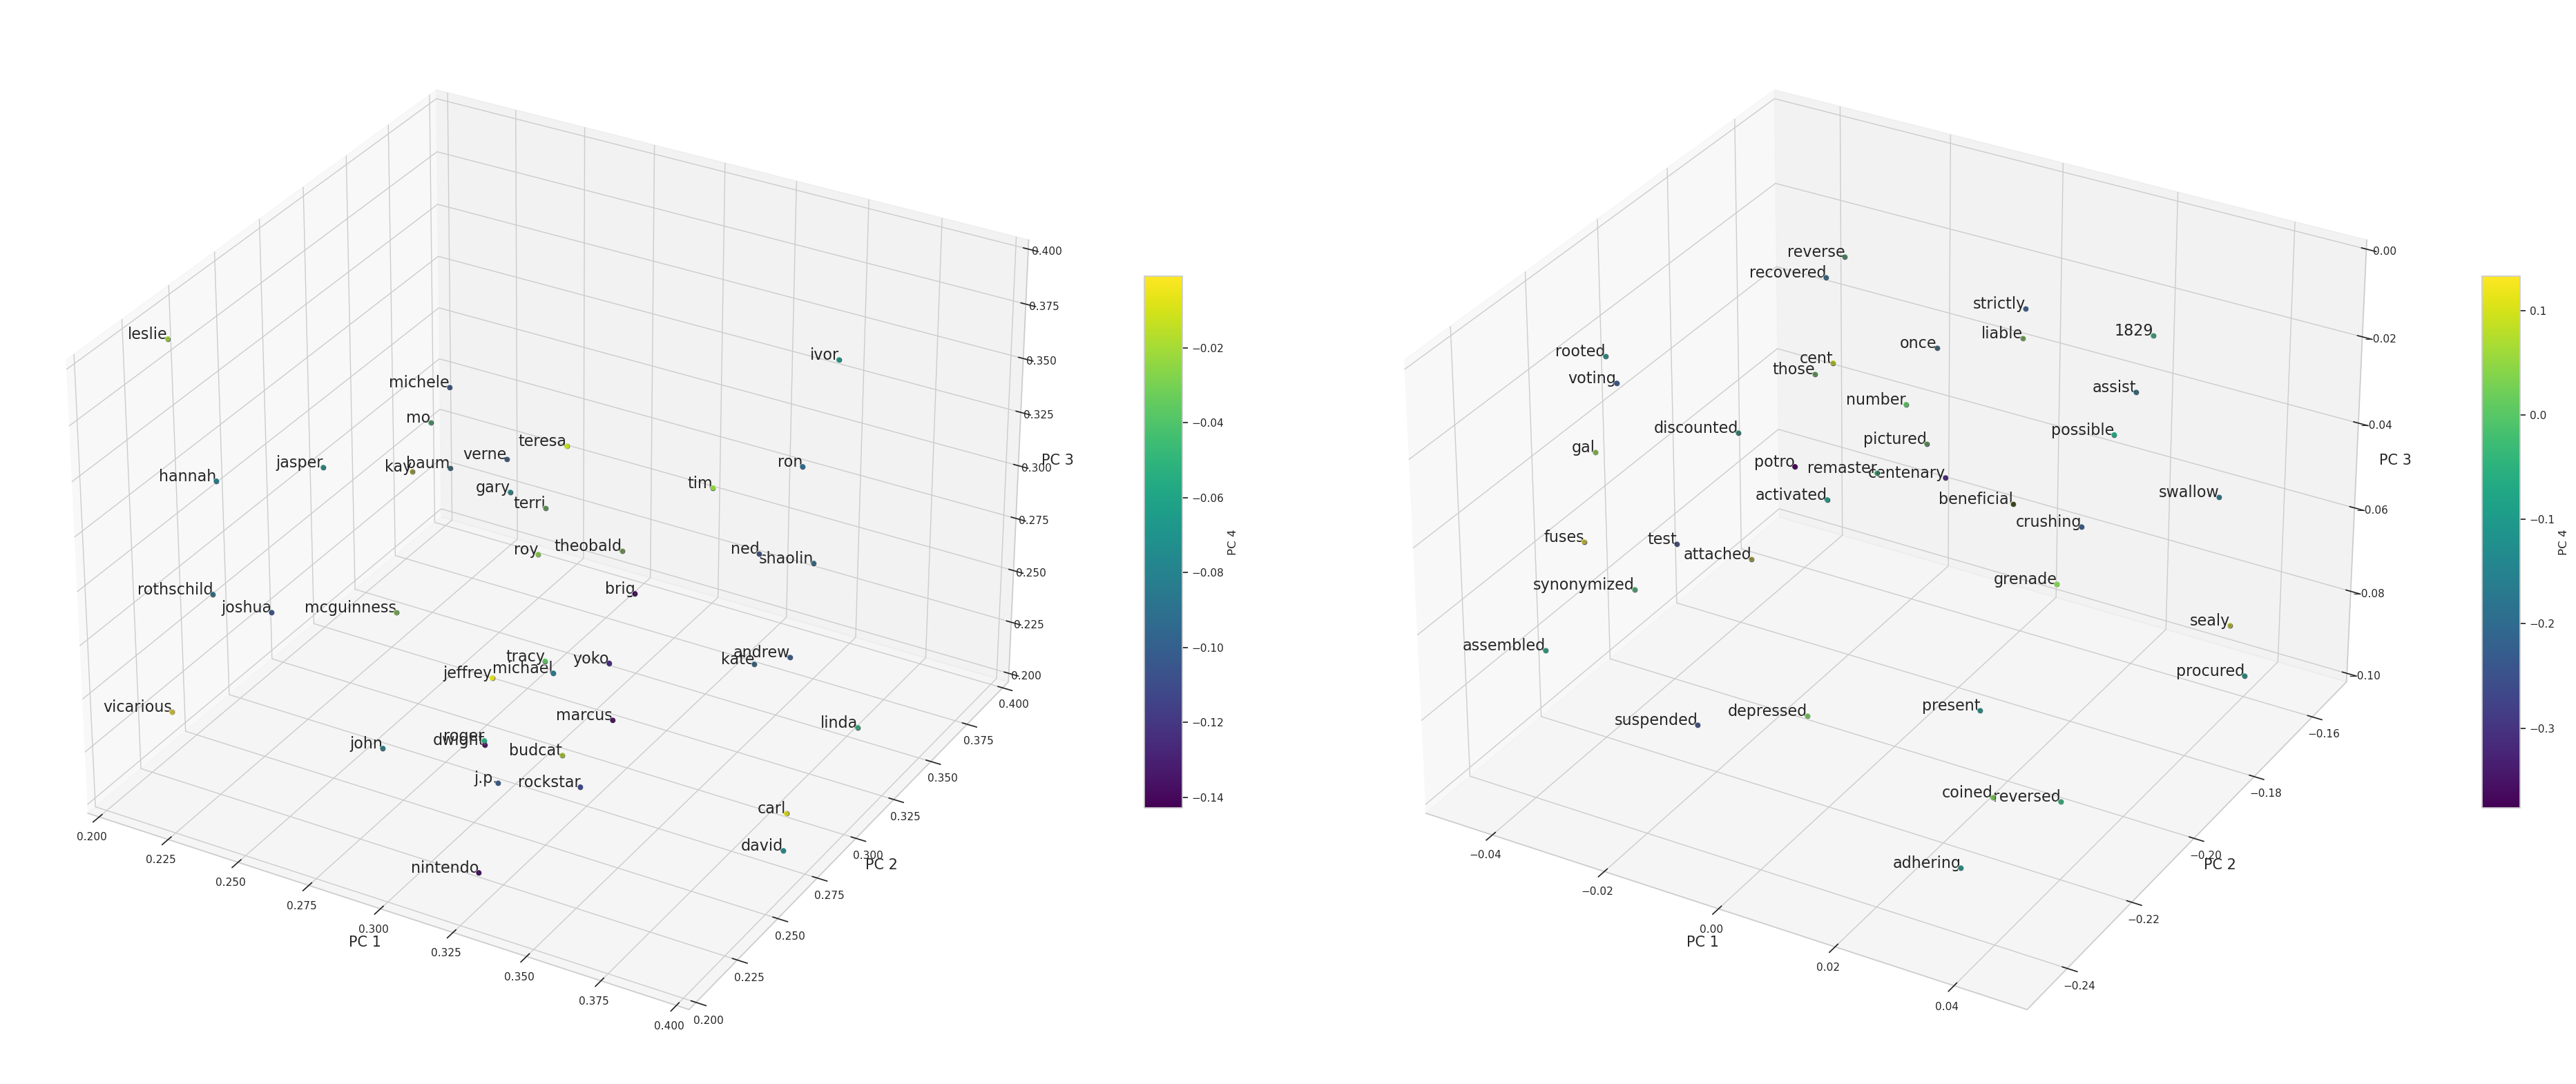

In [ ]:
# Initialize
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 25), subplot_kw={'projection': '3d'})


# Region of interest
roi1 = {'x_lim': [0.2, 0.4], 'y_lim': [0.2, 0.4], 'z_lim': [0.2, 0.4], 'fourth_dim_lim': [-0.15, 0]}
roi2 = {'x_lim': [-0.05, 0.05], 'y_lim': [-0.25, -.15], 'z_lim': [-0.1, 0], 'fourth_dim_lim': [-0.4, 0.15]}


# Step 0: Set the random seed for reproducibility
np.random.seed(1000)

embeddings = model.embedding(torch.tensor(np.arange(vocab_size))).detach().cpu().numpy()
pca = PCA(n_components=4)
reduced_embeddings = pca.fit_transform(embeddings)


# Filtering and Plotting
for ax, roi in zip([ax1, ax2], [roi1, roi2]):
    indices = filter_indices_based_on_region(reduced_embeddings, **roi)
    sampled_embeddings = reduced_embeddings[indices]
    sampled_words = [train_vocabBuilder.index2word[i] for i in indices]
    fourth_dim_values = reduced_embeddings[indices, 3]

    # Call plot_data without the 'fourth_dim_lim' argument
    plot_data(ax, embeddings=sampled_embeddings, words=sampled_words, fourth_dim_values=fourth_dim_values, reduced_embeddings=sampled_embeddings, **{k: v for k, v in roi.items() if k != 'fourth_dim_lim'})

# Adjust subplot spacing
plt.subplots_adjust(wspace=0)

# Save the figure and show it
plt.savefig('embedding_vis.png')
plt.show()
